In [1]:
# Evaluación de scNovel con conjunto de datos de células cerebrales (Darmanis)
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn.metrics
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from collections import Counter
import copy

### =============================================================
### Conjunto de datos de células cerebrales (Darmanis)
### ==============================================================

El conjunto de datos de expresión unicelular Darmanis contiene información detallada sobre 466 células individuales y está organizado en 9 tipos distintos, que incluye neuro-nas y varios tipos de células gliales. El dataset se originó a partir de un estudio pionero centrado en la transcriptómica de células individuales de la corteza cerebral humana, convirtiéndose en una referencia ampliamente utilizada en la comunidad científica

### =============================================================
### Lectura y carga del conjunto de datos de células cerebrales (Darmanis)
### ==============================================================

In [3]:
#Lectura del archivo de etiquetas "darmanis_label.csv"
label = sc.read_csv('darmanis_label.csv',dtype="str")
#Carga de la matriz de recuentos de expresión génica en un objeto AnnData
adata = sc.read_csv("darmanis_counts.csv")
#Conversión del objeto AnnData a un DataFrame de pandas para facilitar el manejo de los datos
data = adata.to_df()

In [4]:
adata
# data

AnnData object with n_obs × n_vars = 466 × 22088

### ==============================================================
### Preprocesamiento de los datos y construcción del dataset
###  ==============================================================

Antes de comenzar a construir el dataset, preprocesaremos los datos. Como se ha explicado con detalle en la memoria, el preprocesamiento consta de una normalización y una transformación logarítmica.


In [8]:
# Normalizamos los datos de expresión génica para que cada célula tenga el mismo total de cuentas (por defecto, 10,000).
# Esto corrige las diferencias en la profundidad de secuenciación entre células, permitiendo comparaciones justas entre ellas
sc.pp.normalize_total(adata, target_sum=1e4)

# Aplicamos una transformación logarítmica (log(x+1)) a los datos normalizados.
# Esta transformación reduce la dispersión y estabiliza la varianza, facilitando el análisis posterior y la identificación de patrones biológicos relevantes
sc.pp.log1p(adata)

def build_dataset(adata_this,label_this,drop_number=1):
    # Copiamos los datos de entrada para no modificar los originales
    adata=adata_this
    label=label_this.to_df()
     # Mostramos el tamaño del dataset
    print("Dataset Size {}".format(len(adata)))
    # Comprobamos que el número de datos coincide con el número de etiquetas
    assert len(adata)==len(label),"Data Length {} Does not Match Label Length {}".format(len(adata),len(label))

    # Obtenemos las etiquetas únicas presentes en el dataset
    set_label=np.unique(label.values)
    print(set_label)

    # Contamos cuántas células hay de cada tipo de etiqueta
    count=[]
    for label_index in range(len(set_label)):
        # print(label.values==set_label[label_index])
        sum_number=sum(label.values==set_label[label_index])
        count.append(sum_number[0])
        print("Label {}: {}".format(set_label[label_index],sum_number))
    print(count)
    print(np.array(count))
    print(np.argmin(count))


    min_index=np.argsort(count)[:drop_number]
    print(min_index)

    # Guardamos las etiquetas correspondientes a los clústeres/células raras
    min_label=[]
    for i in min_index:
        min_label.append(set_label[i])
    print(min_label)
    print("Rare Cell Name {}: {}".format(min_label,[count[count_i] for count_i in min_index]))

    # Creamos un diccionario para mapear las etiquetas a nuevos valores
    label_map={}
    count_map=0
     # Asignamos nuevos valores a las etiquetas mayoritarias (ID)
    for label_index in range(len(set_label)):
        if not label_index in min_index:
            label_map[set_label[label_index]]=count_map
            count_map+=1
    print(label_map)
    count_map_temp=count_map
    # Asignamos nuevos valores a las etiquetas raras (OOD)
    for label_index in range(len(set_label)):
        if label_index in min_index:
            label_map[set_label[label_index]]=count_map_temp
            count_map_temp+=1
    # label_map[min_label]=count_map
    print(label_map)

    # Extraemos las células raras (OOD) usando las etiquetas identificadas
    test_extract_ood = label.isin(min_label)
    label_ood = label.loc[test_extract_ood.values]
    X_test_ood=adata.loc[test_extract_ood.values]
    # print(label_ood.values[0])
    # Extraemos las células mayoritarias (ID)
    adata_id = adata.loc[~test_extract_ood.values]
    label_id = label.loc[~test_extract_ood.values]

    # Dividimos las células ID en conjunto de entrenamiento y test usando train_test_split
    X_train, X_test, y_train, y_test = train_test_split(adata_id,label_id,random_state=42,stratify=label_id)
    print(X_train)
    print(y_train)
    return X_train,X_test,y_train,y_test,X_test_ood,label_ood
X_train,X_test,y_train,y_test,X_test_ood,label_ood=build_dataset(data,label,drop_number=1)
true_label=np.zeros(len(X_test)+len(X_test_ood))
true_label[:len(X_test)]+=1

Dataset Size 466
['"OPC"' '"astrocytes"' '"endothelial"' '"fetal_quiescent"'
 '"fetal_replicating"' '"hybrid"' '"microglia"' '"neurons"'
 '"oligodendrocytes"']
Label "OPC": [18]
Label "astrocytes": [62]
Label "endothelial": [20]
Label "fetal_quiescent": [110]
Label "fetal_replicating": [25]
Label "hybrid": [46]
Label "microglia": [16]
Label "neurons": [131]
Label "oligodendrocytes": [38]
[18, 62, 20, 110, 25, 46, 16, 131, 38]
[ 18  62  20 110  25  46  16 131  38]
6
[6]
['"microglia"']
Rare Cell Name ['"microglia"']: [16]
{'"OPC"': 0, '"astrocytes"': 1, '"endothelial"': 2, '"fetal_quiescent"': 3, '"fetal_replicating"': 4, '"hybrid"': 5, '"neurons"': 6, '"oligodendrocytes"': 7}
{'"OPC"': 0, '"astrocytes"': 1, '"endothelial"': 2, '"fetal_quiescent"': 3, '"fetal_replicating"': 4, '"hybrid"': 5, '"neurons"': 6, '"oligodendrocytes"': 7, '"microglia"': 8}
                               1/2-SBSRNA4  A1BG  A1BG-AS1  A1CF  A2LD1  \
GSM1658333_nochipID13.C75.csv          0.0   0.0       0.0   0.0


La anterior función (build_dataset()) se crea para preparar los datos de expresión génica y sus etiquetas asociadas con el objetivo de entrenar y evaluar modelos de clasificación, centrándose especialmente en la detección de tipos celulares raros/novedosos. 

El procedimiento consiste en identificar la clase de célula menos abundante en el conjunto de datos (o las menos abundantes, según el parámetro `drop_number`) y separarla para simular un escenario de out-of-disribution (OOD), es decir, de clases que no se han visto durante el entrenamiento. 
1) Primero, se comprueba que el número de muestras y etiquetas coincida y se identifican todas las clases presentes.
3) A continuación, se cuenta cuántas células hay de cada tipo para localizar las clases más raras. 
4) Una vez identificadas, estas se separan del resto: las células de las clases raras se reservan para el test OOD, mientras que el resto se consideran in-distribution (ID) y se dividen, de forma estratificada, en conjuntos de entrenamiento y prueba. De este modo, el modelo puede entrenarse solo con las clases frecuentes y luego evaluarse tanto en datos similares a los vistos como en ejemplos de las clases raras, lo que permite analizar su capacidad de detección de tipos celulares novedosos.

El resultado de la función son los conjuntos de entrenamiento y prueba para las clases frecuentes, junto con los datos y etiquetas correspondientes a las clases raras, listos para su uso con scNovel.

Unimos los conjuntos de test estándar (X_test) y de test OOD (X_test_ood) en un único DataFrame.
De este modo, test_all contiene tanto las células frecuentes (in-distribution) como las raras (out-of-distribution),
lo que permite evaluar el rendimiento del modelo sobre ambos tipos de población en un solo análisis.


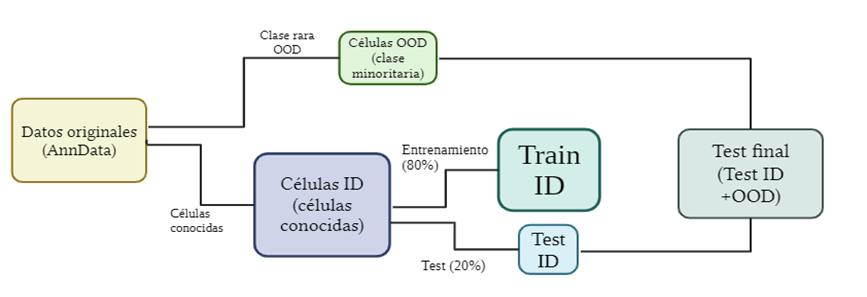

In [12]:
test_all=pd.concat([X_test,X_test_ood])
print(test_all)

                               1/2-SBSRNA4      A1BG  A1BG-AS1  A1CF  A2LD1  \
GSM1658101_nochipID3.C61.csv      0.000000  0.000000       0.0   0.0    0.0   
GSM1658350_nochipID4.C41.csv      0.000000  0.000000       0.0   0.0    0.0   
GSM1658047_nochipID2.C50.csv      0.027735  0.000000       0.0   0.0    0.0   
GSM1658327_nochipID13.C66.csv     0.000000  0.000000       0.0   0.0    0.0   
GSM1658003_nochipID15.C54.csv     0.000000  0.202021       0.0   0.0    0.0   
...                                    ...       ...       ...   ...    ...   
GSM1657925_1772078218.C88.csv     0.000000  0.000000       0.0   0.0    0.0   
GSM1657926_1772078218.C89.csv     0.000000  0.000000       0.0   0.0    0.0   
GSM1657927_1772078218.C93.csv     0.000000  0.000000       0.0   0.0    0.0   
GSM1657934_1772078236.C25.csv     0.000000  0.000000       0.0   0.0    0.0   
GSM1658116_nochipID5.C04.csv      0.000000  0.000000       0.0   0.0    0.0   

                                    A2M     A2ML1  

### ==============================================
### Evaluación de scNovel
### ==============================================

En este paso se utiliza la función scRare para puntuar todas las muestras del conjunto de test,
empleando el conjunto de entrenamiento y sus etiquetas como referencia. El objetivo es evaluar
la capacidad del modelo para identificar células raras o OOD a partir de
los datos de expresión génica. 

In [126]:
import scNovel as sr

# La función recibe como entrada el conjunto de test (test_all), los datos de entrenamiento (X_train)
# y una copia profunda de las etiquetas de entrenamiento (y_train), lo que asegura que las etiquetas
# originales no se vean modificadas durante el proceso.
#
# El parámetro 'processing_unit' se establece en 'cuda' para que los cálculos se realicen en la GPU,
# acelerando significativamente la ejecución en comparación con la CPU. Se utiliza 'sim' como función
# de puntuación y esto indica que la similitud será el criterio para evaluar la cercanía entre las
# muestras de test y las del entrenamiento. Además, se fija el número de iteraciones en 3000, lo que
# permite al algoritmo ajustar sus parámetros y obtener puntuaciones más estables y fiables.
#
# El resultado, almacenado en test_score, es una puntuación para cada muestra del conjunto de test,
# que posteriormente puede utilizarse para analizar el rendimiento del modelo en la detección de
# células raras/novedosas.

test_score = sr.scRare(test_all,X_train, copy.deepcopy(y_train), processing_unit='cuda',  score_function='sim',iteration_number=3000)



--------Start annotating----------
Computational unit be used is: cpu
Finish 11.0/3000
Finish 22.0/3000
Finish 33.0/3000
Finish 44.0/3000
Finish 55.0/3000
Finish 66.0/3000
Finish 77.0/3000
Finish 88.0/3000
Finish 99.0/3000
Finish 110.0/3000
Finish 121.0/3000
Finish 132.0/3000
Finish 143.0/3000
Finish 154.0/3000
Finish 165.0/3000
Finish 176.0/3000
Finish 187.0/3000
Finish 198.0/3000
Finish 209.0/3000
Finish 220.0/3000
Finish 231.0/3000
Finish 242.0/3000
Finish 253.0/3000
Finish 264.0/3000
Finish 275.0/3000
Finish 286.0/3000
Finish 297.0/3000
Finish 308.0/3000
Finish 319.0/3000
Finish 330.0/3000
Finish 341.0/3000
Finish 352.0/3000
Finish 363.0/3000
Finish 374.0/3000
Finish 385.0/3000
Finish 396.0/3000
Finish 407.0/3000
Finish 418.0/3000
Finish 429.0/3000
Finish 440.0/3000
Finish 451.0/3000
Finish 462.0/3000
Finish 473.0/3000
Finish 484.0/3000
Finish 495.0/3000
Finish 506.0/3000
Finish 517.0/3000
Finish 528.0/3000
Finish 539.0/3000
Finish 550.0/3000
Finish 561.0/3000
Finish 572.0/3000
Fin

### =============================================================
### Evaluación del rendimiento de scNovel
### =============================================================

El AUROC (Área Bajo la Curva ROC) es una de las métricas más robustas y amplia-mente utilizadas para evaluar modelos de clasificación. Esta métrica es mayoritariamen-te usada cuando las clases se encuentran más desbalanceadas. La curva ROC (Recei-ver Operating Characteristic) muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos para todos los posibles umbrales de decisión

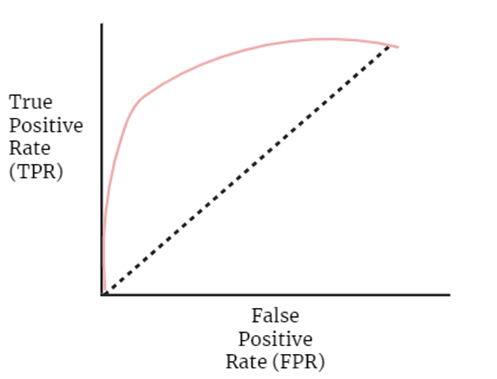

Calculamos el área bajo la curva ROC (AUROC) como métrica principal de evaluación del modelo.

In [130]:

# La función roc_auc_score de scikit-learn compara las etiquetas verdaderas (true_label) con las puntuaciones de predicción (test_score)
# y devuelve un valor entre 0 y 1 que indica la capacidad del modelo para distinguir entre las clases.
# Un AUROC cercano a 1 significa que el modelo separa correctamente las clases, mientras que valores cercanos a 0.5 indican que el modelo no discrimina mejor que el azar.



auroc=sklearn.metrics.roc_auc_score(true_label,test_score)
print(auroc)

0.9012721238938053


In [132]:
print(true_label)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [134]:
#Se imprimirán las funciones proporcionadas por el paquete scNovel
import scNovel
print(dir(scNovel))

help(scNovel)

['Data', 'Weighted_Sampling', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'classifier', 'get_ood_scores', 'nn', 'np', 'scNovel_classifier', 'scRare', 'score_functions', 'time', 'torch', 'weightsampling']
Help on package scNovel:

NAME
    scNovel

PACKAGE CONTENTS
    scNovel_IO
    scNovel_classifier
    score_functions
    weightsampling

FUNCTIONS
    scRare(test=None, reference=None, label=None, processing_unit='cuda', score_function='sim', iteration_number=3000)
        :param test: Input your test dataset to annotate
        :param reference: Input your reference dataset
        :param label: Input label set
        :param processing_unit: Choose which processing unit you would like to use,
        if you choose 'gpu', than the software will try to access CUDA,
        if you choose 'cpu', the software will use CPU as default.
        :return:

FILE
    c:\users\34635\anaconda3\lib\site-packages\scnovel\__i

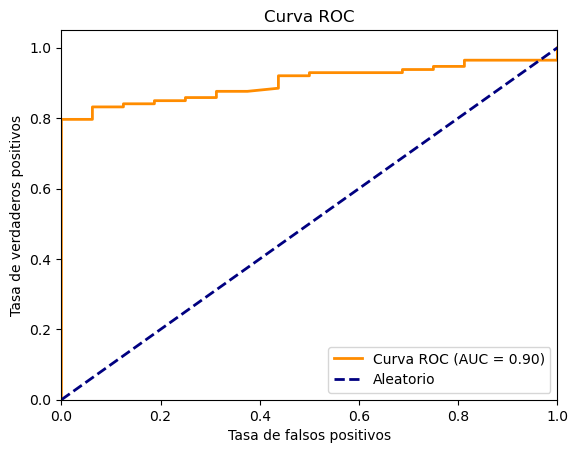

In [136]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculamos las tasas de falsos positivos y verdaderos positivos
fpr, tpr, thresholds = roc_curve(true_label, test_score)

# Calculamos el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Dibujamos la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Con un resultado de AUROC de un 0.90 aproximadamente, podemos confirmar que la detección de células novedosas/raras en el conjunto de datos de Darmanis (células cerebrales) se ha efectuado con éxito.